In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import tensorflow as tf
from scipy.stats import skew
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import backend as K
from keras.callbacks import EarlyStopping, LearningRateScheduler

### Consumer Prices

In [2]:
# Load the first dataset
consumer_prices_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv'
consumer_prices_data = pd.read_csv(consumer_prices_path)

# Display the first few rows and the columns of the dataset
consumer_prices_data.head(), consumer_prices_data.columns

(  Domain Code                  Domain  Area Code (M49)         Area  \
 0          CP  Consumer Price Indices                4  Afghanistan   
 1          CP  Consumer Price Indices                4  Afghanistan   
 2          CP  Consumer Price Indices                4  Afghanistan   
 3          CP  Consumer Price Indices                4  Afghanistan   
 4          CP  Consumer Price Indices                4  Afghanistan   
 
    Year Code  Year  Item Code                                        Item  \
 0       2000  2000      23013  Consumer Prices, Food Indices (2015 = 100)   
 1       2000  2000      23013  Consumer Prices, Food Indices (2015 = 100)   
 2       2000  2000      23013  Consumer Prices, Food Indices (2015 = 100)   
 3       2000  2000      23013  Consumer Prices, Food Indices (2015 = 100)   
 4       2000  2000      23013  Consumer Prices, Food Indices (2015 = 100)   
 
    Months Code    Months  Element Code Element Unit      Value Flag  \
 0         7001   Januar

### Crops production indicators

In [3]:
# Load the second dataset
crops_production_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Crops production indicators - FAOSTAT_data_en_2-22-2024.csv'
crops_production_data = pd.read_csv(crops_production_path)

# Display the first few rows and the columns of the dataset
crops_production_data.head(), crops_production_data.columns

(  Domain Code                        Domain  Area Code (M49)         Area  \
 0         QCL  Crops and livestock products                4  Afghanistan   
 1         QCL  Crops and livestock products                4  Afghanistan   
 2         QCL  Crops and livestock products                4  Afghanistan   
 3         QCL  Crops and livestock products                4  Afghanistan   
 4         QCL  Crops and livestock products                4  Afghanistan   
 
    Element Code Element Item Code (CPC)              Item  Year Code  Year  \
 0          5419   Yield           F1717  Cereals, primary       2000  2000   
 1          5419   Yield           F1717  Cereals, primary       2001  2001   
 2          5419   Yield           F1717  Cereals, primary       2002  2002   
 3          5419   Yield           F1717  Cereals, primary       2003  2003   
 4          5419   Yield           F1717  Cereals, primary       2004  2004   
 
        Unit  Value Flag Flag Description  Note  
 0  

Since we are focusing on annual predictions, we will aggregate the "Consumer Prices" data to an annual level before merging.

1. **Aggregate "Consumer Prices" Data**: Calculate the annual average for each country and item.
2. **Merge with "Crops Production"**: Combine these datasets using 'Area' and 'Year' as keys.

Let's start by aggregating the "Consumer Prices" data and then proceed to merge it with the "Crops Production" data.

In [4]:
# Aggregate 'Consumer Prices' data to annual level by calculating the mean value for each 'Area' and 'Year'
consumer_prices_annual = consumer_prices_data.groupby(['Area', 'Year']).agg({'Value': 'mean'}).reset_index()

# Merge 'Consumer Prices' annual data with 'Crops Production' data
merged_data = pd.merge(consumer_prices_annual, crops_production_data, on=['Area', 'Year'], how='inner')

# Display the first few rows and columns of the merged dataset to verify the merge
merged_data.head(), merged_data.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 1  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 2  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 3  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 4  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1804   
 2                4          5419   Yield          F17530   
 3                4          5419   Yield           F1738   
 4                4          5419   Yield           F1841   
 
                             Item  Year Code      Unit  Value_y Flag  \
 0               Cereals, primary       2000  100 g/ha     8063    A   
 1            Citr

### Emission Dataset

Next, we'll merge the combined data with the "Emissions" dataset. 

In [5]:
# Load the "Emissions" dataset
emissions_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Emissions - FAOSTAT_data_en_2-27-2024.csv'
emissions_data = pd.read_csv(emissions_path)

# Display the first few rows and the columns of the dataset
emissions_data.head(), emissions_data.columns

(  Domain Code                Domain  Area Code (M49)         Area  \
 0         GCE  Emissions from Crops                4  Afghanistan   
 1         GCE  Emissions from Crops                4  Afghanistan   
 2         GCE  Emissions from Crops                4  Afghanistan   
 3         GCE  Emissions from Crops                4  Afghanistan   
 4         GCE  Emissions from Crops                4  Afghanistan   
 
    Element Code                      Element Item Code (CPC)       Item  \
 0         72430  Crops total (Emissions N2O)           F1712  All Crops   
 1         72440  Crops total (Emissions CH4)           F1712  All Crops   
 2         72430  Crops total (Emissions N2O)           F1712  All Crops   
 3         72440  Crops total (Emissions CH4)           F1712  All Crops   
 4         72430  Crops total (Emissions N2O)           F1712  All Crops   
 
    Year Code  Year  Source Code      Source Unit    Value Flag  \
 0       2000  2000         3050  FAO TIER 1   kt   0

The "Emissions" dataset includes important fields like 'Area' and 'Year', which align with the keys used for previous merges. This dataset also provides emission data in terms of 'Value' which reflects the emission levels of crops.

**Filter Relevant Fields:** We only need to keep specific fields such as 'Area', 'Year', and 'Value' in this dataset.
as these are the features we will be needing.

In [6]:
# Filter relevant fields from the emissions dataset (assuming we're considering all types of emissions here)
emissions_relevant = emissions_data[['Area', 'Year', 'Value']]

# Group by 'Area' and 'Year' and sum up the emissions values to get a total emission per area per year
emissions_grouped = emissions_relevant.groupby(['Area', 'Year']).agg({'Value': 'sum'}).reset_index()

# Merge the emissions data with the previously merged data
full_merged_data = pd.merge(merged_data, emissions_grouped, on=['Area', 'Year'], how='inner', suffixes=('_prev', '_emissions'))

# Display the first few rows and columns of the new merged dataset to verify the merge
full_merged_data.head(), full_merged_data.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 1  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 2  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 3  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 4  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1804   
 2                4          5419   Yield          F17530   
 3                4          5419   Yield           F1738   
 4                4          5419   Yield           F1841   
 
                             Item  Year Code      Unit  Value_y Flag  \
 0               Cereals, primary       2000  100 g/ha     8063    A   
 1            Citr

The `full_merged_data` dataset includes the emissions data along with the consumer prices and crops production information. The new column labelled 'Value' (renamed during the merge to avoid overlap) represents the total emissions for each area and year, alongside the other variables from previous datasets.

### Employment Dataset

In [7]:
# Load the "Employment" dataset
employment_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Employment - FAOSTAT_data_en_2-27-2024.csv'
employment_data = pd.read_csv(employment_path)

# Display the first few rows and the columns of the dataset
employment_data.head(), employment_data.columns

(  Domain Code                              Domain  Area Code (M49)  \
 0         OEA  Employment Indicators: Agriculture                4   
 1         OEA  Employment Indicators: Agriculture                4   
 2         OEA  Employment Indicators: Agriculture                4   
 3         OEA  Employment Indicators: Agriculture                4   
 4         OEA  Employment Indicators: Agriculture                4   
 
           Area  Indicator Code  \
 0  Afghanistan           21150   
 1  Afghanistan           21150   
 2  Afghanistan           21144   
 3  Afghanistan           21144   
 4  Afghanistan           21144   
 
                                            Indicator  Sex Code    Sex  \
 0  Mean weekly hours actually worked per employed...         1  Total   
 1  Mean weekly hours actually worked per employed...         1  Total   
 2  Employment in agriculture, forestry and fishin...         1  Total   
 3  Employment in agriculture, forestry and fishin...         1 

The "Employment" dataset includes the following key fields:
- 'Area' and 'Year', which match the existing structure of our merged dataset.
- 'Value', representing employment data, possibly in various forms (like hours worked or number employed).

### Merge Strategy:
1. **Filter and Prepare Employment Data**: Since the dataset contains multiple indicators for employment, we use the total number of people employed in agriculture as this has the most direct impact on agricultural export values.
2. **Merge**: Combine this filtered employment data with our existing dataset using 'Area' and 'Year'.

In [8]:
# Filter for total employment in agriculture (using Indicator Code '21144')
employment_agriculture = employment_data[employment_data['Indicator Code'] == 21144]

# Since the dataset might have multiple entries for each area and year, we'll aggregate it by taking the sum
employment_agriculture_grouped = employment_agriculture.groupby(['Area', 'Year']).agg({'Value': 'sum'}).reset_index()

# Merge the filtered and aggregated employment data with the existing merged data
full_merged_data_with_employment = pd.merge(full_merged_data, employment_agriculture_grouped, on=['Area', 'Year'], how='inner', suffixes=('', '_employment'))

# Display the first few rows and columns of the updated merged dataset to verify the merge
full_merged_data_with_employment.head(), full_merged_data_with_employment.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 1  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 2  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 3  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 4  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1804   
 2                4          5419   Yield          F17530   
 3                4          5419   Yield           F1738   
 4                4          5419   Yield           F1841   
 
                             Item  Year Code      Unit  Value_y Flag  \
 0               Cereals, primary       2000  100 g/ha     8063    A   
 1            Citr

The `full_merged_data_with_employment` now includes employment data, specifically the total number of people employed in agriculture, merged with our existing dataset which contains consumer prices, crop production, and emissions data.

### Exchange Rate

In [9]:
# Load the "Exchange Rate" dataset
exchange_rate_path =     r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Exchange rate - FAOSTAT_data_en_2-22-2024.csv'
exchange_rate_data = pd.read_csv(exchange_rate_path)

# Display the first few rows and the columns of the dataset
exchange_rate_data.head(), exchange_rate_data.columns

(  Domain Code          Domain  Area Code (M49)         Area  \
 0          PE  Exchange rates                4  Afghanistan   
 1          PE  Exchange rates                4  Afghanistan   
 2          PE  Exchange rates                4  Afghanistan   
 3          PE  Exchange rates                4  Afghanistan   
 4          PE  Exchange rates                4  Afghanistan   
 
   ISO Currency Code (FAO) Currency Element Code                       Element  \
 0                     AFA  Afghani          LCU  Local currency units per USD   
 1                     AFA  Afghani          LCU  Local currency units per USD   
 2                     AFA  Afghani          LCU  Local currency units per USD   
 3                     AFA  Afghani          LCU  Local currency units per USD   
 4                     AFA  Afghani          LCU  Local currency units per USD   
 
    Year Code  Year  Months Code    Months  Unit      Value Flag  \
 0       1980  1980         7001   January   NaN  44

The `Exchange Rate` dataset includes monthly data with 'Area', 'Year', and 'Value' indicating the local currency units per USD. We aggregate this monthly data into annual averages to align with the rest of our annual data.

#### Steps for Merging:
1. **Aggregate Data**: Calculate the annual average exchange rate for each country.
2. **Merge**: Combine this aggregated data with our existing dataset.

In [10]:
# Aggregate the exchange rate data to annual level by calculating the mean value for each 'Area' and 'Year'
exchange_rate_annual = exchange_rate_data.groupby(['Area', 'Year']).agg({'Value': 'mean'}).reset_index()

# Merge the aggregated exchange rate data with the existing merged data
full_merged_data_with_exchange_rate = pd.merge(full_merged_data_with_employment, exchange_rate_annual, on=['Area', 'Year'], how='inner', suffixes=('', '_exchange_rate'))

# Display the first few rows and columns of the updated merged dataset to verify the merge
full_merged_data_with_exchange_rate.head(), full_merged_data_with_exchange_rate.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 1  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 2  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 3  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 4  Afghanistan  2000  26.629848         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1804   
 2                4          5419   Yield          F17530   
 3                4          5419   Yield           F1738   
 4                4          5419   Yield           F1841   
 
                             Item  Year Code      Unit  Value_y Flag  \
 0               Cereals, primary       2000  100 g/ha     8063    A   
 1            Citr

The `full_merged_data_with_exchange_rate` dataset includes the aggregated exchange rate data along with the previously merged information on consumer prices, crop production, emissions, and employment. Each entry now also has an annual average exchange rate for the respective area and year.

### Fertilizers Use

In [11]:
# Load the "Fertilizers Use" dataset
fertilizers_use_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Fertilizers use - FAOSTAT_data_en_2-27-2024.csv'
fertilizers_use_data = pd.read_csv(fertilizers_use_path)

# Display the first few rows and the columns of the dataset
fertilizers_use_data.head(), fertilizers_use_data.columns

(  Domain Code                  Domain  Area Code (M49)         Area  \
 0         RFB  Fertilizers by Product                4  Afghanistan   
 1         RFB  Fertilizers by Product                4  Afghanistan   
 2         RFB  Fertilizers by Product                4  Afghanistan   
 3         RFB  Fertilizers by Product                4  Afghanistan   
 4         RFB  Fertilizers by Product                4  Afghanistan   
 
    Element Code           Element  Item Code             Item  Year Code  \
 0          5157  Agricultural Use       4021  NPK fertilizers       2002   
 1          5157  Agricultural Use       4021  NPK fertilizers       2003   
 2          5157  Agricultural Use       4021  NPK fertilizers       2004   
 3          5157  Agricultural Use       4001             Urea       2004   
 4          5157  Agricultural Use       4001             Urea       2005   
 
    Year Unit    Value Flag Flag Description  
 0  2002    t  17900.0    I    Imputed value  
 1  2003

The `Fertilizers Use` dataset contains annual data with fields such as 'Area', 'Year', and 'Value' showing the usage of different fertilizers.

### Steps for Merging:
1. **Aggregate Data**: Sum up the total usage of all types of fertilizers per area per year to get a single value representing total fertilizer use.
2. **Merge**: Combine this aggregated data with our existing dataset.

In [12]:
# Aggregate the fertilizers use data to sum the total usage for each 'Area' and 'Year'
fertilizers_use_aggregated = fertilizers_use_data.groupby(['Area', 'Year']).agg({'Value': 'sum'}).reset_index()

# Merge the aggregated fertilizers use data with the existing merged data
full_merged_data_with_fertilizers = pd.merge(full_merged_data_with_exchange_rate, fertilizers_use_aggregated, on=['Area', 'Year'], how='inner', suffixes=('', '_fertilizers'))

# Display the first few rows and columns of the updated merged dataset to verify the merge
full_merged_data_with_fertilizers.head(), full_merged_data_with_fertilizers.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2002  26.799704         QCL  Crops and livestock products   
 1  Afghanistan  2002  26.799704         QCL  Crops and livestock products   
 2  Afghanistan  2002  26.799704         QCL  Crops and livestock products   
 3  Afghanistan  2002  26.799704         QCL  Crops and livestock products   
 4  Afghanistan  2002  26.799704         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1804   
 2                4          5419   Yield          F17530   
 3                4          5419   Yield           F1738   
 4                4          5419   Yield           F1841   
 
                             Item  Year Code      Unit  Value_y Flag  \
 0               Cereals, primary       2002  100 g/ha    16698    A   
 1            Citr

The `full_merged_data_with_fertilizers` dataset includes the aggregated fertilizer use data, alongside the previous data on consumer prices, crop production, emissions, employment, and exchange rates. The added column `Value_fertilizers` represents the total amount of fertilizers used annually per area.

### Food Balances

In [13]:
# Load the "Food Balances" dataset
food_balances_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Food balances indicators - FAOSTAT_data_en_2-22-2024.csv'
food_balances_data = pd.read_csv(food_balances_path)

# Display the first few rows and the columns of the dataset
food_balances_data.head(), food_balances_data.columns

(  Domain Code                 Domain  Area Code (M49)         Area  \
 0         FBS  Food Balances (2010-)                4  Afghanistan   
 1         FBS  Food Balances (2010-)                4  Afghanistan   
 2         FBS  Food Balances (2010-)                4  Afghanistan   
 3         FBS  Food Balances (2010-)                4  Afghanistan   
 4         FBS  Food Balances (2010-)                4  Afghanistan   
 
    Element Code          Element Item Code (FBS)                      Item  \
 0          5611  Import Quantity           S2905  Cereals - Excluding Beer   
 1          5611  Import Quantity           S2905  Cereals - Excluding Beer   
 2          5611  Import Quantity           S2905  Cereals - Excluding Beer   
 3          5611  Import Quantity           S2905  Cereals - Excluding Beer   
 4          5611  Import Quantity           S2905  Cereals - Excluding Beer   
 
    Year Code  Year    Unit   Value Flag Flag Description  
 0       2010  2010  1000 t  2000.0 

The `Food Balances` dataset includes fields such as 'Area', 'Year', and 'Value', along with specifics about different food items and elements like import and export quantities. This data provides a detailed perspective on the supply side, particularly imports and exports, which are critical for understanding crop export values.

### Steps for Merging:
1. **Filter and Aggregate Data**: To keep our focus on export-related aspects, we will filter and aggregate the data to include the total export quantities of all items per area per year.
2. **Merge**: Integrate this data with our existing dataset.

In [14]:
# Filter for export quantities (assuming Element Code for export quantities, here taking a general approach)
food_balances_exports = food_balances_data[food_balances_data['Element'] == 'Export Quantity']

# Aggregate the data to sum the total exports for each 'Area' and 'Year'
food_balances_exports_aggregated = food_balances_exports.groupby(['Area', 'Year']).agg({'Value': 'sum'}).reset_index()

# Merge the aggregated food balances export data with the existing merged data
full_merged_data_with_food_balances = pd.merge(full_merged_data_with_fertilizers, food_balances_exports_aggregated, on=['Area', 'Year'], how='inner', suffixes=('', '_food_balances'))

# Display the first few rows and columns of the updated merged dataset to verify the merge
full_merged_data_with_food_balances.head(), full_merged_data_with_food_balances.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 1  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 2  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 3  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 4  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1804   
 2                4          5419   Yield          F17530   
 3                4          5419   Yield           F1738   
 4                4          5419   Yield           F1841   
 
                             Item  ...      Unit Value_y  Flag  \
 0               Cereals, primary  ...  100 g/ha   20111     A   
 1            Citrus Fruit, To

The `full_merged_data_with_food_balances` dataset includes aggregated food balances data, specifically the total export quantities, along with the previously merged information. The new column `Value_food_balances` represents the total export quantities of food products annually per area.

### Food Security

In [15]:
# Load the "Food Security" dataset
food_security_data = pd.read_csv(r"C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024\Food security indicators  - FAOSTAT_data_en_2-22-2024.csv")
food_security_data.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FS,Suite of Food Security Indicators,4,Afghanistan,6121,Value,21010,Average dietary energy supply adequacy (percen...,20002002,2000-2002,%,88.0,E,Estimated value,NaN
1,FS,Suite of Food Security Indicators,4,Afghanistan,6121,Value,21010,Average dietary energy supply adequacy (percen...,20012003,2001-2003,%,89.0,E,Estimated value,NaN
2,FS,Suite of Food Security Indicators,4,Afghanistan,6121,Value,21010,Average dietary energy supply adequacy (percen...,20022004,2002-2004,%,92.0,E,Estimated value,NaN
3,FS,Suite of Food Security Indicators,4,Afghanistan,6121,Value,21010,Average dietary energy supply adequacy (percen...,20032005,2003-2005,%,93.0,E,Estimated value,NaN
4,FS,Suite of Food Security Indicators,4,Afghanistan,6121,Value,21010,Average dietary energy supply adequacy (percen...,20042006,2004-2006,%,94.0,E,Estimated value,NaN


The `Food Security` dataset includes data that is period-specific and summarised over multiple years (e.g., 2000-2002).  The dataset includes:
- `Area` 
- `Year` (in a range format)
- `Value` (various metrics of food security, such as dietary energy supply adequacy).


### Steps for Merging "Food Security" Data:
1. **Preprocess Data**: To accommodate the year range data in the "Food Security" dataset, we process the 'Year' column by associating each metric with the ending year of the range. For example, data from "2000-2002" is treated as applicable to 2002. This aligns the multi-year data with the annual format of our existing dataset.

2. **Select Relevant Metrics**: We identify and select the food security metrics that are most relevant to forecasting crop export values. This involves focusing on specific indicators that directly relate to the availability or stability of food supplies, which are critical factors influencing export potential.

3. **Aggregate Data**: Given that the food security data covers various metrics over different periods, we aggregate these metrics by calculating the relevant statistical measure for each area and processed year. This ensures that each year's data represents a comprehensive view of the food security status pertinent to that year.

4. **Merge**: The aggregated food security data is then merged with the existing dataset (`full_merged_data_with_food_balances`).

In [16]:
# Function to extract the ending year from the range in the 'Year' column
def extract_year(year_range):
    return int(year_range.split('-')[-1])

# Apply the function to create a new column for the single year
food_security_data['Year'] = food_security_data['Year'].apply(extract_year)

# Assuming we're aggregating all metrics for simplicity (you can choose specific metrics as needed)
food_security_aggregated = food_security_data.groupby(['Area', 'Year']).agg({'Value': 'mean'}).reset_index()

In [17]:
# Merge the food security data with the existing data
full_merged_data_with_food_security = pd.merge(full_merged_data_with_food_balances, food_security_aggregated, on=['Area', 'Year'], how='inner', suffixes=('', '_food_security'))

# View the first few rows to confirm
print(full_merged_data_with_food_security.head())

          Area  Year    Value_x Domain Code                        Domain  \
0  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
1  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
2  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
3  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
4  Afghanistan  2010  37.589202         QCL  Crops and livestock products   

   Area Code (M49)  Element Code Element Item Code (CPC)  \
0                4          5419   Yield           F1717   
1                4          5419   Yield           F1804   
2                4          5419   Yield          F17530   
3                4          5419   Yield           F1738   
4                4          5419   Yield           F1841   

                            Item  ...  Value_y Flag  Flag Description Note  \
0               Cereals, primary  ...    20111    A   Official figure  NaN   
1            Citrus 

### Foreign Direct Investment (FDI)

In [18]:
# Load the "Foreign Direct Investment" dataset
fdi_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv'
fdi_data = pd.read_csv(fdi_path)

# Display the first few rows and the columns of the dataset
fdi_data.head(), fdi_data.columns

(  Domain Code                           Domain  Area Code (M49)         Area  \
 0         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
 1         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
 2         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
 3         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
 4         FDI  Foreign Direct Investment (FDI)                4  Afghanistan   
 
    Element Code    Element  Item Code               Item  Year Code  Year  \
 0          6110  Value US$      23082  Total FDI inflows       2000  2000   
 1          6110  Value US$      23082  Total FDI inflows       2001  2001   
 2          6110  Value US$      23082  Total FDI inflows       2002  2002   
 3          6110  Value US$      23082  Total FDI inflows       2003  2003   
 4          6110  Value US$      23082  Total FDI inflows       2004  2004   
 
           Unit   Value Flag              

The `Foreign Direct Investment (FDI)` dataset includes annual data on investment flows, specifically 'Area', 'Year', and 'Value', which represents the total FDI inflows in millions of USD. This data provides insights into economic conditions that might influence agricultural productivity and export capabilities.

### Steps for Merging:
1. **Filter and Aggregate Data**: Aggregate FDI data per area and year to ensure it aligns with our existing data format.
2. **Merge**: Combine this data with our existing dataset.

In [19]:
# Merge the FDI data with the existing merged data
full_merged_data_with_fdi = pd.merge(full_merged_data_with_food_security, fdi_data[['Area', 'Year', 'Value']], on=['Area', 'Year'], how='inner', suffixes=('', '_fdi'))

# Display the first few rows and columns of the updated merged dataset to verify the merge
full_merged_data_with_fdi.head(), full_merged_data_with_fdi.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 1  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 2  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 3  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 4  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1717   
 2                4          5419   Yield           F1804   
 3                4          5419   Yield           F1804   
 4                4          5419   Yield          F17530   
 
                             Item  ...  Flag Flag Description  Note    Value  \
 0               Cereals, primary  ...     A  Official figure   NaN  34.1185   
 1

The `full_merged_data_with_fdi` dataset includes the Foreign Direct Investment (FDI) data, which provides insights into economic investments that could affect agricultural productivity and export potential. The new column `Value_fdi` represents the total FDI inflows in millions of USD per area per year.

### Land Temperature Change

In [20]:
# Load the "Land Temperature Change" dataset
land_temperature_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Land temperature change - FAOSTAT_data_en_2-27-2024.csv'
land_temperature_data = pd.read_csv(land_temperature_path)

# Display the first few rows and the columns of the dataset
land_temperature_data.head(), land_temperature_data.columns

(  Domain Code                      Domain  Area Code (M49)         Area  \
 0          ET  Temperature change on land                4  Afghanistan   
 1          ET  Temperature change on land                4  Afghanistan   
 2          ET  Temperature change on land                4  Afghanistan   
 3          ET  Temperature change on land                4  Afghanistan   
 4          ET  Temperature change on land                4  Afghanistan   
 
    Element Code             Element  Months Code       Months  Year Code  \
 0          7271  Temperature change         7016  Dec–Jan–Feb       2000   
 1          7271  Temperature change         7016  Dec–Jan–Feb       2001   
 2          7271  Temperature change         7016  Dec–Jan–Feb       2002   
 3          7271  Temperature change         7016  Dec–Jan–Feb       2003   
 4          7271  Temperature change         7016  Dec–Jan–Feb       2004   
 
    Year Unit  Value Flag Flag Description  
 0  2000   °c  0.618    E  Estima

The `Land Temperature Change` dataset includes temperature change data, which is given in degrees Celsius ('°c') for various months and years. The dataset includes fields like 'Area', 'Year', and 'Value' showing the temperature change for each area and year.

### Steps for Merging:
1. **Aggregate Data**: Calculate the annual average temperature change for each 'Area' and 'Year'. Given that the temperature data is seasonal (noted by 'Months'), we first aggregate this to an annual level for each area and year, then proceed with the merge.
2. **Merge**: Combine this aggregated temperature data with our existing dataset.

In [21]:
# Aggregate the land temperature data to annual level by calculating the mean value for each 'Area' and 'Year'
land_temperature_annual = land_temperature_data.groupby(['Area', 'Year']).agg({'Value': 'mean'}).reset_index()

# Merge the aggregated land temperature data with the existing merged data
full_merged_data_with_temperature = pd.merge(full_merged_data_with_fdi, land_temperature_annual, on=['Area', 'Year'], how='inner', suffixes=('', '_temp_change'))

# Display the first few rows and columns of the updated merged dataset to verify the merge
full_merged_data_with_temperature.head(), full_merged_data_with_temperature.columns

(          Area  Year    Value_x Domain Code                        Domain  \
 0  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 1  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 2  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 3  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 4  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
 
    Area Code (M49)  Element Code Element Item Code (CPC)  \
 0                4          5419   Yield           F1717   
 1                4          5419   Yield           F1717   
 2                4          5419   Yield           F1804   
 3                4          5419   Yield           F1804   
 4                4          5419   Yield          F17530   
 
                             Item  ...  Flag Description Note    Value  \
 0               Cereals, primary  ...   Official figure  NaN  34.1185   
 1            

The `full_merged_data_with_temperature` dataset includes annual average temperature changes, enhancing our analysis with climate-related data that could affect agricultural productivity. The new column `Value_temp_change` represents the mean annual temperature change for each area and year.

### Land Use

In [22]:
# Load the "Land Use" dataset
land_use_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Land use - FAOSTAT_data_en_2-22-2024.csv'
data_types = {14: str} # Specify dtype option on import and also set low_memory=False
land_use_data = pd.read_csv(land_use_path, dtype=data_types, low_memory=False)

# Display the first few rows and the columns of the dataset
land_use_data.head(), land_use_data.columns

(  Domain Code    Domain  Area Code (M49)         Area  Element Code Element  \
 0          RL  Land Use                4  Afghanistan          5110    Area   
 1          RL  Land Use                4  Afghanistan          5110    Area   
 2          RL  Land Use                4  Afghanistan          5110    Area   
 3          RL  Land Use                4  Afghanistan          5110    Area   
 4          RL  Land Use                4  Afghanistan          5110    Area   
 
    Item Code          Item  Year Code  Year     Unit    Value Flag  \
 0       6600  Country area       1980  1980  1000 ha  65286.0    A   
 1       6600  Country area       1981  1981  1000 ha  65286.0    A   
 2       6600  Country area       1982  1982  1000 ha  65286.0    A   
 3       6600  Country area       1983  1983  1000 ha  65286.0    A   
 4       6600  Country area       1984  1984  1000 ha  65286.0    A   
 
   Flag Description Note  
 0  Official figure  NaN  
 1  Official figure  NaN  
 2  Offic

### Steps for Merging:
1. **Aggregate Data**: Average the land use data per area and year. The dataset appears to be in an appropriate format with 'Area' and 'Year' fields clearly defined, and 'Value' representing the land area in thousands of hectares, needing no further preprocessing.
2. **Merge**: Combine this data with our existing dataset.

In [23]:
full_merged_data_with_land_use = pd.merge(full_merged_data_with_temperature, land_use_data[['Area', 'Year', 'Value']], on=['Area', 'Year'], how='inner', suffixes=('', '_land_use'))

# To check the first few rows to ensure the merge went as expected
print(full_merged_data_with_land_use.head())
print(full_merged_data_with_land_use.columns)

          Area  Year    Value_x Domain Code                        Domain  \
0  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
1  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
2  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
3  Afghanistan  2010  37.589202         QCL  Crops and livestock products   
4  Afghanistan  2010  37.589202         QCL  Crops and livestock products   

   Area Code (M49)  Element Code Element Item Code (CPC)              Item  \
0                4          5419   Yield           F1717  Cereals, primary   
1                4          5419   Yield           F1717  Cereals, primary   
2                4          5419   Yield           F1717  Cereals, primary   
3                4          5419   Yield           F1717  Cereals, primary   
4                4          5419   Yield           F1717  Cereals, primary   

   ...  Note    Value  Value_employment Value_exchange_rate Value_fe

### Pesticides use

In [24]:
# Load the "Pesticides use" dataset
pesticides_use_path =     r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Pesticides use - FAOSTAT_data_en_2-27-2024.csv'
#data_types = {14: str} # Specify dtype option on import and also set low_memory=False
pesticides_use_data = pd.read_csv(pesticides_use_path)

# Display the first few rows and the columns of the dataset
pesticides_use_data.head(), pesticides_use_data.columns

(  Domain Code          Domain  Area Code (M49)     Area  Element Code  \
 0          RP  Pesticides Use                8  Albania          5157   
 1          RP  Pesticides Use                8  Albania          5159   
 2          RP  Pesticides Use                8  Albania          5173   
 3          RP  Pesticides Use                8  Albania          5157   
 4          RP  Pesticides Use                8  Albania          5159   
 
                                     Element  Item Code                Item  \
 0                          Agricultural Use       1357  Pesticides (total)   
 1                  Use per area of cropland       1357  Pesticides (total)   
 2  Use per value of agricultural production       1357  Pesticides (total)   
 3                          Agricultural Use       1357  Pesticides (total)   
 4                  Use per area of cropland       1357  Pesticides (total)   
 
    Year Code  Year    Unit   Value Flag Flag Description Note  
 0       2000

The `Pesticides Use` dataset includes multiple metrics related to pesticide use in agriculture, which can provide insights into the intensity of agricultural practices and their potential environmental impacts.

### Steps for Merging:
1. **Aggregate Data**: Given that the dataset includes different units and types of usage metrics (e.g., total quantity, usage per area, per value of production), we focus on "Agricultural Use" in terms of total quantity (in tons), as this provides a direct measure of pesticide use. This ensures the data's relevance to crop production.
2. **Merge**: Combine the aggregated pesticide data with the existing dataset.

In [25]:
# Perform the filter and aggregate operations
pesticides_agricultural_use = pesticides_use_data[
    (pesticides_use_data['Element'] == 'Agricultural Use') &
    (pesticides_use_data['Unit'] == 't')
]
pesticides_use_aggregated = pesticides_agricultural_use.groupby(['Area', 'Year']).agg({'Value': 'sum'}).reset_index()

# Merge operation
full_merged_data_with_pesticides = pd.merge(
    full_merged_data_with_land_use, 
    pesticides_use_aggregated, 
    on=['Area', 'Year'], 
    how='inner', 
    suffixes=('', '_pesticides')
)

print(full_merged_data_with_pesticides.head())
print(full_merged_data_with_pesticides.columns)

      Area  Year    Value_x Domain Code                        Domain  \
0  Albania  2010  44.727208         QCL  Crops and livestock products   
1  Albania  2010  44.727208         QCL  Crops and livestock products   
2  Albania  2010  44.727208         QCL  Crops and livestock products   
3  Albania  2010  44.727208         QCL  Crops and livestock products   
4  Albania  2010  44.727208         QCL  Crops and livestock products   

   Area Code (M49)  Element Code Element Item Code (CPC)              Item  \
0                8          5419   Yield           F1717  Cereals, primary   
1                8          5419   Yield           F1717  Cereals, primary   
2                8          5419   Yield           F1717  Cereals, primary   
3                8          5419   Yield           F1717  Cereals, primary   
4                8          5419   Yield           F1717  Cereals, primary   

   ...     Value Value_employment  Value_exchange_rate Value_fertilizers  \
0  ...  110.2303

### Food Trade

In [26]:
# Load the "Food Trade" dataset
food_trade_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\OneDrive_1_22-03-2024_updated\Food trade indicators - FAOSTAT_data_en_2-22-2024.csv'

food_trade_data = pd.read_csv(food_trade_path)

# Display the first few rows and the columns of the dataset
food_trade_data.head(), food_trade_data.columns

(  Domain Code                        Domain  Area Code (M49)         Area  \
 0         TCL  Crops and livestock products                4  Afghanistan   
 1         TCL  Crops and livestock products                4  Afghanistan   
 2         TCL  Crops and livestock products                4  Afghanistan   
 3         TCL  Crops and livestock products                4  Afghanistan   
 4         TCL  Crops and livestock products                4  Afghanistan   
 
    Element Code       Element Item Code (CPC)                      Item  \
 0          5622  Import Value           F1888  Cereals and Preparations   
 1          5622  Import Value           F1888  Cereals and Preparations   
 2          5622  Import Value           F1888  Cereals and Preparations   
 3          5622  Import Value           F1888  Cereals and Preparations   
 4          5622  Import Value           F1888  Cereals and Preparations   
 
    Year Code  Year      Unit    Value Flag Flag Description  Note  
 0 

The `Food Trade` dataset contains detailed information about trade values of various agricultural products, categorised under imports and exports, which are key indicators for our analysis. The dataset includes fields like 'Area', 'Year', and 'Value' that indicate the financial aspect of trade in terms of USD.

### Steps for Merging:
1. **Aggregate Data**: For simplicity, we sum up the total export values for each 'Area' and 'Year'.
2. **Merge**: Combine this aggregated trade data with our existing dataset.

In [27]:
# Filter for export values (assuming Element Code for export values)
food_trade_exports = food_trade_data[food_trade_data['Element'] == 'Export Value']

# Aggregate the data to sum the total exports for each 'Area' and 'Year'
food_trade_exports_aggregated = food_trade_exports.groupby(['Area', 'Year']).agg({'Value': 'sum'}).reset_index()

# Renaming the 'Value' column to 'Total_Export_Value' to clearly identify it as the target variable
food_trade_exports_aggregated.rename(columns={'Value': 'Total_Export_Value'}, inplace=True)

# Merge the aggregated food trade export data with the existing merged data
full_merged_data_with_food_trade = pd.merge(full_merged_data_with_pesticides, food_trade_exports_aggregated, on=['Area', 'Year'], how='inner', suffixes=('', '_food_trade'))

# Save merge data
#path_to_save = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\MACHINE LEARNING\Assignment\Merged_data.csv'
#full_merged_data_with_food_trade.to_csv(path_to_save, index=False)

# Display the first few rows and columns of the updated merged dataset to verify the merge
print(full_merged_data_with_food_trade.head())
print(full_merged_data_with_food_trade.columns)

      Area  Year    Value_x Domain Code                        Domain  \
0  Albania  2010  44.727208         QCL  Crops and livestock products   
1  Albania  2010  44.727208         QCL  Crops and livestock products   
2  Albania  2010  44.727208         QCL  Crops and livestock products   
3  Albania  2010  44.727208         QCL  Crops and livestock products   
4  Albania  2010  44.727208         QCL  Crops and livestock products   

   Area Code (M49)  Element Code Element Item Code (CPC)              Item  \
0                8          5419   Yield           F1717  Cereals, primary   
1                8          5419   Yield           F1717  Cereals, primary   
2                8          5419   Yield           F1717  Cereals, primary   
3                8          5419   Yield           F1717  Cereals, primary   
4                8          5419   Yield           F1717  Cereals, primary   

   ...  Value_employment Value_exchange_rate  Value_fertilizers  \
0  ...            459.46 

In [28]:
full_merged_data_with_food_trade.head()

,Area,Year,Value_x,Domain Code,Domain,Area Code (M49),Element Code,Element,Item Code (CPC),Item,...,Value_employment,Value_exchange_rate,Value_fertilizers,Value_food_balances,Value_food_security,Value_fdi,Value_temp_change,Value_land_use,Value_pesticides,Total_Export_Value
0,Albania,2010,44.727208,QCL,Crops and livestock products,8,5419,Yield,F1717,"Cereals, primary",...,459.46,103.936667,114737.0,52.41,41.481,-0.613208,0.9632,2875.0,1173.25,60447.0
1,Albania,2010,44.727208,QCL,Crops and livestock products,8,5419,Yield,F1717,"Cereals, primary",...,459.46,103.936667,114737.0,52.41,41.481,-0.613208,0.9632,2740.0,1173.25,60447.0
2,Albania,2010,44.727208,QCL,Crops and livestock products,8,5419,Yield,F1717,"Cereals, primary",...,459.46,103.936667,114737.0,52.41,41.481,-0.613208,0.9632,1201.3,1173.25,60447.0
3,Albania,2010,44.727208,QCL,Crops and livestock products,8,5419,Yield,F1717,"Cereals, primary",...,459.46,103.936667,114737.0,52.41,41.481,-0.613208,0.9632,1201.3,1173.25,60447.0
4,Albania,2010,44.727208,QCL,Crops and livestock products,8,5419,Yield,F1717,"Cereals, primary",...,459.46,103.936667,114737.0,52.41,41.481,-0.613208,0.9632,696.0,1173.25,60447.0


The `full_merged_data_with_food_trade` dataset includes the aggregated food trade data, specifically the total export values, alongside previously merged information such as crop production, emissions, employment, exchange rates, fertilizer use, food balances, etc. The new column `Total_Export_Value` represents the total export values of food products annually per area.

### Isolate the Target for Model Training:

In [29]:
X = full_merged_data_with_food_trade.drop(['Total_Export_Value'], axis=1)  # This is the feature set
y = full_merged_data_with_food_trade['Total_Export_Value']  # This is the target(label) variable

# Create a deep copy of the merged data before any preprocessing for future use
original_X = X.copy(deep=True)

In [30]:
X.columns

Index(['Area', 'Year', 'Value_x', 'Domain Code', 'Domain', 'Area Code (M49)',
       'Element Code', 'Element', 'Item Code (CPC)', 'Item', 'Year Code',
       'Unit', 'Value_y', 'Flag', 'Flag Description', 'Note', 'Value',
       'Value_employment', 'Value_exchange_rate', 'Value_fertilizers',
       'Value_food_balances', 'Value_food_security', 'Value_fdi',
       'Value_temp_change', 'Value_land_use', 'Value_pesticides'],
      dtype='object')

## Initial Data Inspection:

To effectively inspect the fully merged dataset, we will examine several aspects of the data to understand its structure, check for inconsistencies, and identify potential areas that require cleaning or transformation. 

In [31]:
# Display basic information about the dataset
print("Dataset shape:", X.shape)
print("\nData Types:\n", X.dtypes)

# Display the first few rows of the dataset
print("\nFirst few rows:\n", X.head())

# Display summary statistics for numerical features
print("\nSummary Statistics:\n", X.describe())

# Check for missing values
print("\nMissing Values:\n", X.isnull().sum())

# Check for unique values in 'Area' and 'Year'
print("\nUnique Areas:", X['Area'].nunique())
print("Unique Years:", X['Year'].nunique())

# Display correlation matrix
# Calculate correlation matrix for numeric columns only
numeric_cols = X.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

Dataset shape: (380647, 26)

Data Types:
 Area                    object
Year                     int64
Value_x                float64
Domain Code             object
Domain                  object
Area Code (M49)          int64
Element Code             int64
Element                 object
Item Code (CPC)         object
Item                    object
Year Code                int64
Unit                    object
Value_y                  int64
Flag                    object
Flag Description        object
Note                   float64
Value                  float64
Value_employment       float64
Value_exchange_rate    float64
Value_fertilizers      float64
Value_food_balances    float64
Value_food_security    float64
Value_fdi              float64
Value_temp_change      float64
Value_land_use         float64
Value_pesticides       float64
dtype: object

First few rows:
       Area  Year    Value_x Domain Code                        Domain  \
0  Albania  2010  44.727208         QCL  Crops 

In [32]:
X['Note']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
380642   NaN
380643   NaN
380644   NaN
380645   NaN
380646   NaN
Name: Note, Length: 380647, dtype: float64

## Comprehensive Data Summary Before Preprocessing

Let's have a quick overview of the merged data to understand the approach to take in preprocessing

### 1. **Descriptive Statistics and Quick Overview**

In [33]:
# Display summary statistics for all numerical columns
print(X.describe())

                Year        Value_x  Area Code (M49)  Element Code  \
count  380647.000000  380647.000000    380647.000000      380647.0   
mean     2014.727698      52.261822       422.238596        5419.0   
std         3.509466      13.284817       251.344898           0.0   
min      2010.000000      14.370703         8.000000        5419.0   
25%      2011.000000      47.660669       208.000000        5419.0   
50%      2015.000000      50.695417       392.000000        5419.0   
75%      2018.000000      53.753435       608.000000        5419.0   
max      2021.000000     229.439545       894.000000        5419.0   

           Year Code       Value_y  Note          Value  Value_employment  \
count  380647.000000  3.806470e+05   0.0  380647.000000     380647.000000   
mean     2014.727698  1.365130e+05   NaN    7288.950796       7216.824877   
std         3.509466  1.954335e+05   NaN   27486.741758      28978.841061   
min      2010.000000  0.000000e+00   NaN       0.000000      

### 2. **Visulisation for All Numeric Fields**
Let's plot boxplots across multiple variables to gain a quick visual summary of the central values, spreads, ranges, and outliers.

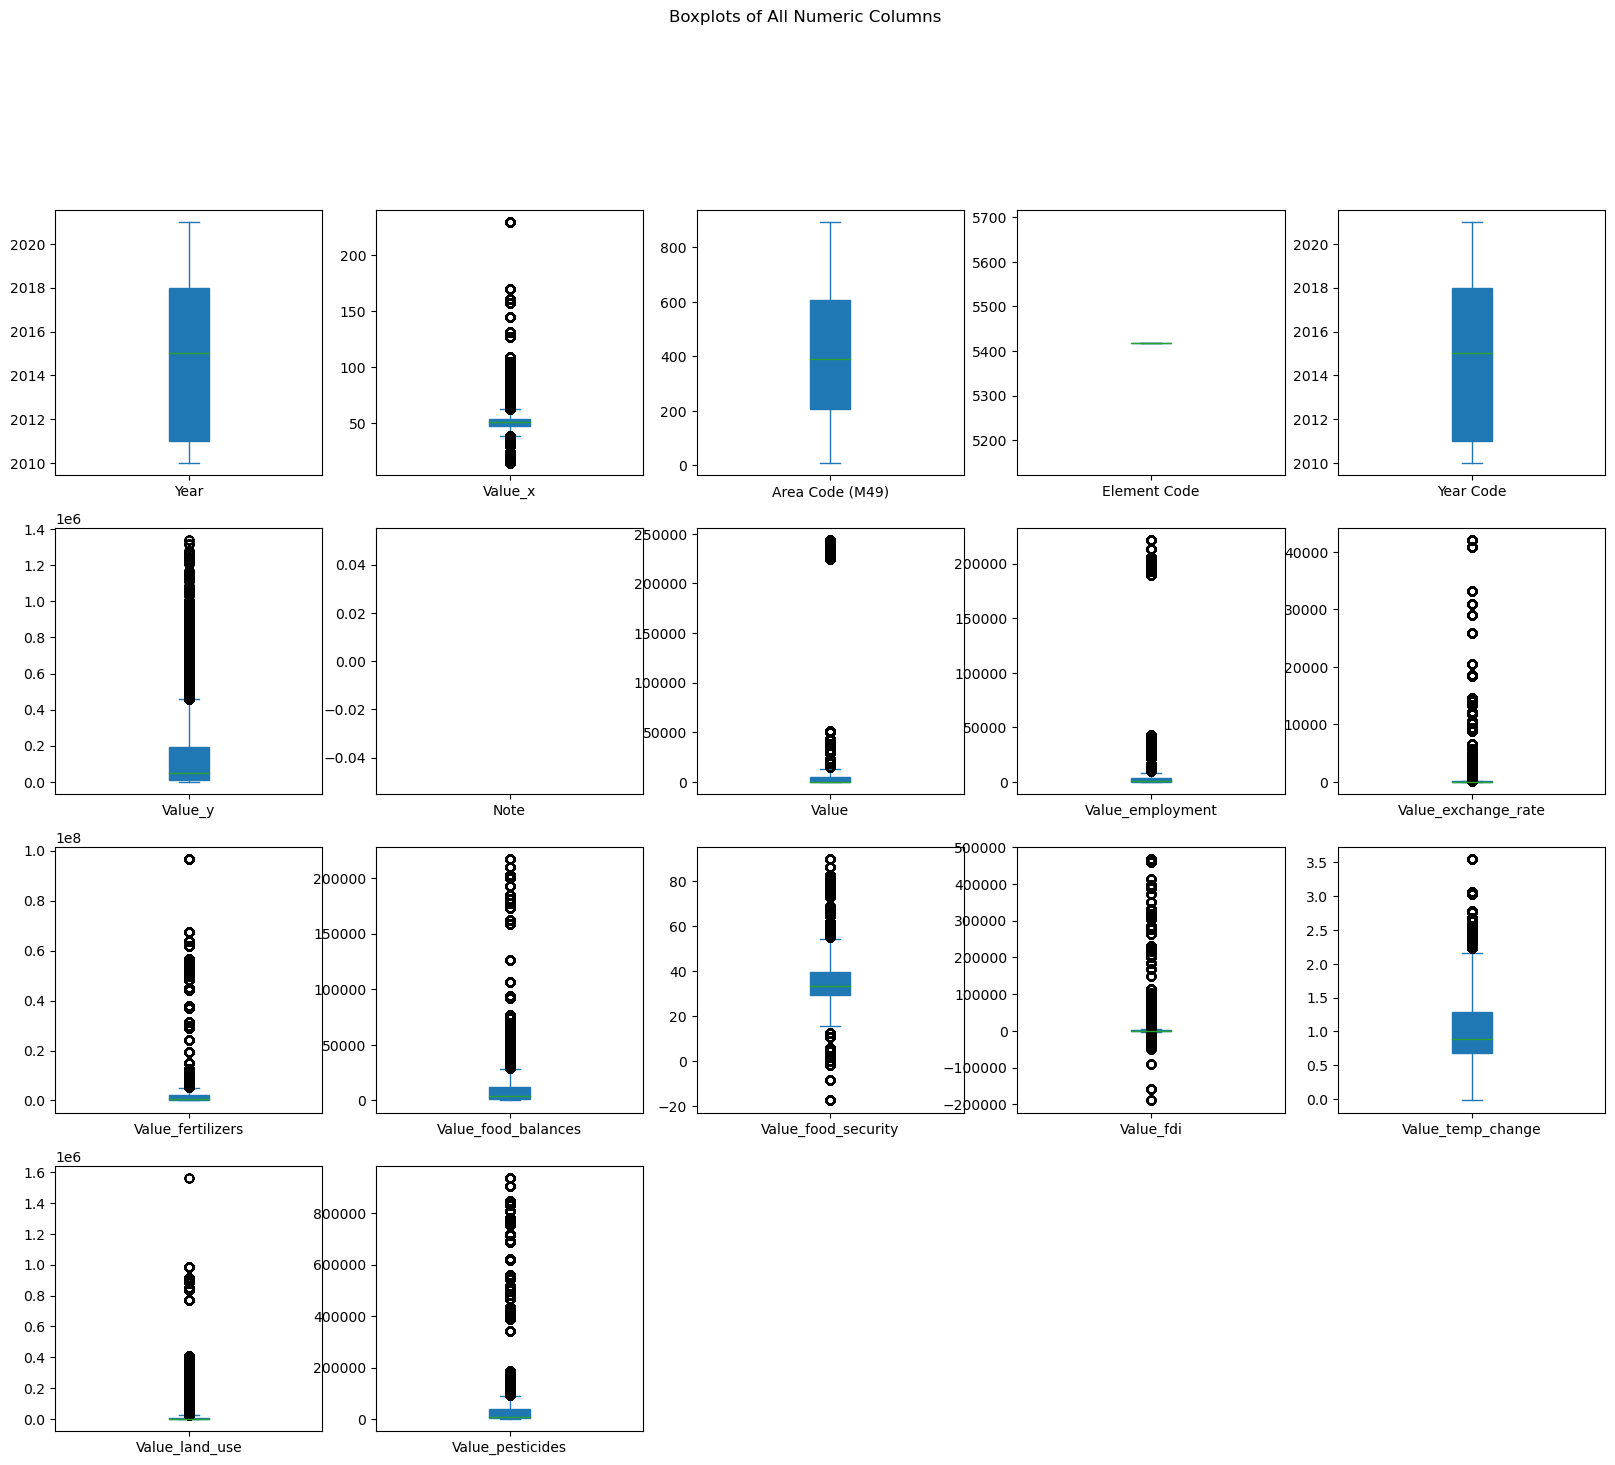

In [34]:
# Boxplots for all numeric columns
numeric_cols = X.select_dtypes(include=['float64', 'int64'])
numeric_cols.plot(kind='box', subplots=True, layout=(5,5), figsize=(20, 20), patch_artist=True)
plt.suptitle('Boxplots of All Numeric Columns')
plt.show()

## Preprocessing

### Handling Missing Values

From the descriptive statistics above and the visualisation,
- The column `Note` has all missing values (380647 entries). We will drop this column.
- `Value_temp_change` has 1128 missing entries which need handling.

In [35]:
# Drop the 'Note' column
X.drop('Note', axis=1, inplace=True)
# full_merged_data_with_pesticides['Note']

In [36]:
# Impute missing values for 'Value_temp_change' using the median
temp_change_median = X['Value_temp_change'].median()
X['Value_temp_change'].fillna(temp_change_median, inplace=True)

# Check if any more missing values
print(X.isnull().sum())

Area                   0
Year                   0
Value_x                0
Domain Code            0
Domain                 0
Area Code (M49)        0
Element Code           0
Element                0
Item Code (CPC)        0
Item                   0
Year Code              0
Unit                   0
Value_y                0
Flag                   0
Flag Description       0
Value                  0
Value_employment       0
Value_exchange_rate    0
Value_fertilizers      0
Value_food_balances    0
Value_food_security    0
Value_fdi              0
Value_temp_change      0
Value_land_use         0
Value_pesticides       0
dtype: int64


### Standardisation
The description statistics has shown that our merged dataset includes very different scales (e.g., `Value_food_trade` in the tens of millions vs. other smaller scale features). We will apply normalisation and standardisation techniques to adjust the scales of the data features.

In [37]:
# Initialize the scalers
scaler = StandardScaler()
#scaler = MinMaxScaler()

# Select numeric columns for scaling
numeric_cols = X.select_dtypes(include=['float64', 'int64'])

# Fit and transform the data
X[numeric_cols.columns] = scaler.fit_transform(numeric_cols)

# Check the transformation
print(X.head())

      Area      Year   Value_x Domain Code                        Domain  \
0  Albania -1.347129 -0.567161         QCL  Crops and livestock products   
1  Albania -1.347129 -0.567161         QCL  Crops and livestock products   
2  Albania -1.347129 -0.567161         QCL  Crops and livestock products   
3  Albania -1.347129 -0.567161         QCL  Crops and livestock products   
4  Albania -1.347129 -0.567161         QCL  Crops and livestock products   

   Area Code (M49)  Element Code Element Item Code (CPC)              Item  \
0        -1.648091           0.0   Yield           F1717  Cereals, primary   
1        -1.648091           0.0   Yield           F1717  Cereals, primary   
2        -1.648091           0.0   Yield           F1717  Cereals, primary   
3        -1.648091           0.0   Yield           F1717  Cereals, primary   
4        -1.648091           0.0   Yield           F1717  Cereals, primary   

   ...     Value Value_employment  Value_exchange_rate Value_fertilizers  

### Normalization
#### Check for Skewed Data

In [38]:
# Calculate skewness for each numeric feature
numeric_cols = X.select_dtypes(include=[np.number])  # Ensure only numeric columns are considered
skewness = numeric_cols.skew()
print(skewness)

Year                   0.201227
Value_x                4.916149
Area Code (M49)        0.167977
Element Code           0.000000
Year Code              0.201227
Value_y                2.325492
Value                  7.299230
Value_employment       6.311004
Value_exchange_rate    7.579044
Value_fertilizers      4.025897
Value_food_balances    3.765680
Value_food_security   -0.242437
Value_fdi              9.623884
Value_temp_change      1.226659
Value_land_use         7.416693
Value_pesticides       3.726900
dtype: float64


The skewness results show that most of the features are significantly skewed. The skewness values above +1 or below -1 suggest that the data distribution is far from normal and could potentially affect the performance of the model.


### Outlier Detection and Handling:
 Here, we applied outlier detection and handling techniques (_i.e.,_ winsorizing) to reduce the effect of outliers.

In [39]:
# Select only the numeric columns from the DataFrame
numeric_cols = X.select_dtypes(include=['number'])

# Calculate the quantiles for numeric columns
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
is_outlier = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))

# Handling outliers, for example, by capping
for column in numeric_cols.columns:
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    numeric_cols[column] = np.where(numeric_cols[column] < lower_bound, lower_bound, numeric_cols[column])
    numeric_cols[column] = np.where(numeric_cols[column] > upper_bound, upper_bound, numeric_cols[column])


# Filling NaNs created by capping with the median
numeric_cols.fillna(numeric_cols.median(), inplace=True)


# Initialize the PowerTransformer with the Yeo-Johnson method
pt = PowerTransformer(method='yeo-johnson')

# Fit and transform the cleaned numeric columns
transformed_columns = pt.fit_transform(numeric_cols)
X.update(pd.DataFrame(transformed_columns, columns=numeric_cols.columns))

# Check the new skewness values
new_skewness = pd.DataFrame(transformed_columns, columns=numeric_cols.columns).skew()
print("New skewness values after Yeo-Johnson transformation:\n", new_skewness)

New skewness values after Yeo-Johnson transformation:
 Year                   0.056615
Value_x               -0.022171
Area Code (M49)        0.015801
Element Code           0.000000
Year Code              0.056615
Value_y                0.443827
Value                  0.776932
Value_employment       0.650349
Value_exchange_rate    0.747770
Value_fertilizers      0.594664
Value_food_balances    0.532072
Value_food_security   -0.020539
Value_fdi             -0.001312
Value_temp_change      0.048663
Value_land_use         0.685198
Value_pesticides       0.647509
dtype: float64


The new skewness values after applying the Yeo-Johnson transformation indicate significant improvement across all the features. The skewness for most variables is now much closer to zero, which suggests that the data distributions have been effectively normalized. 

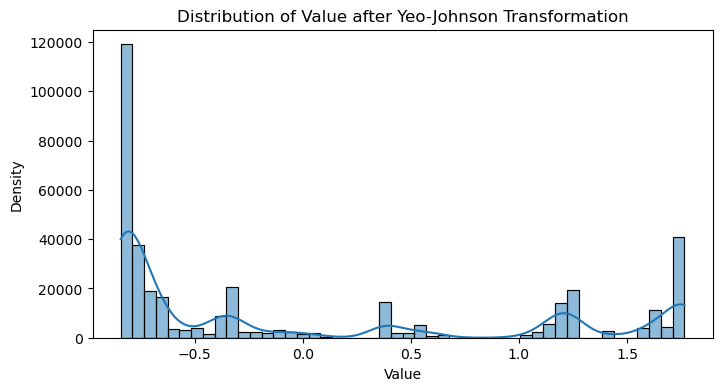

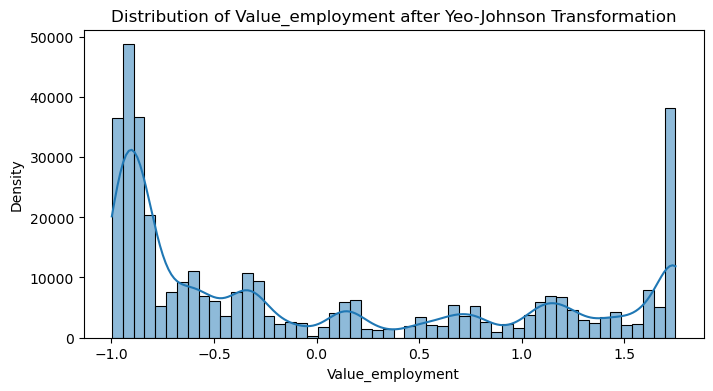

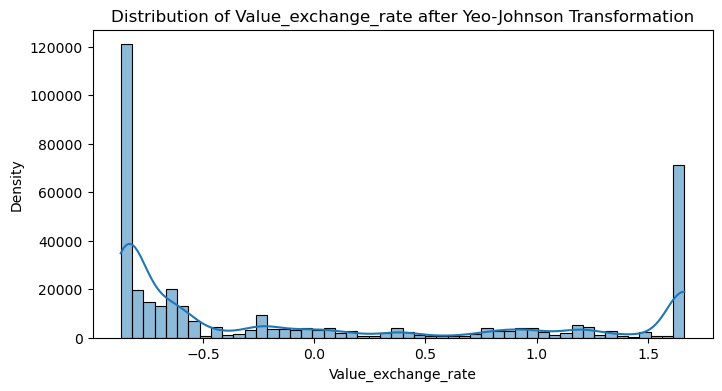

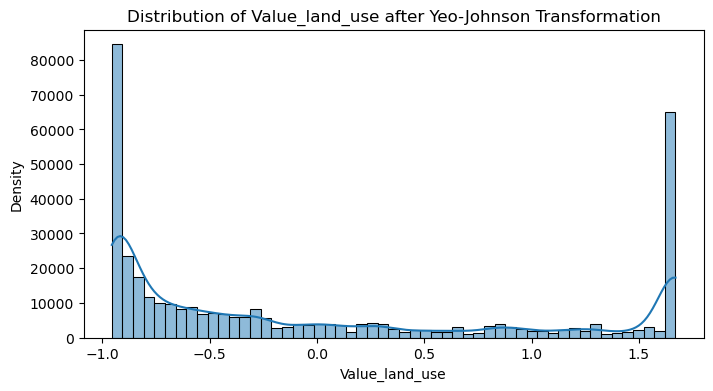

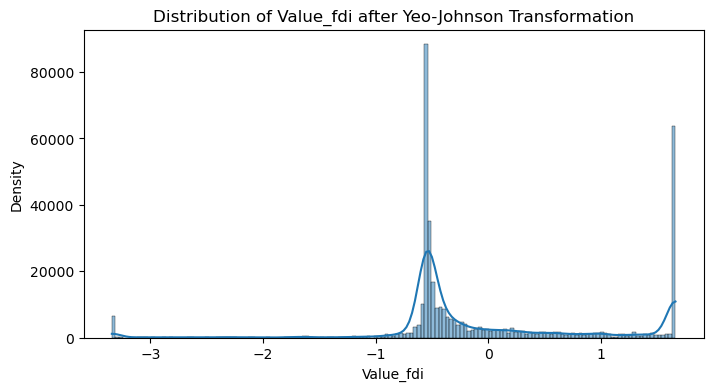

In [40]:
# Visualise the distribution of features with persistent skewness
features_to_plot = ['Value', 'Value_employment','Value_exchange_rate', 'Value_land_use', 'Value_fdi']
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(X[feature], kde=True)
    plt.title(f'Distribution of {feature} after Yeo-Johnson Transformation')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

These distributions show that the transformation has reduced skewness, but they still are not symmetric as some have multiple modes like and others long tails. This may indicate complex underlying distributions or the presence of outliers within the data.




### Encoding Categorical Variables

In [41]:
# Print columns and their data types to help identify categorical columns
print(X.dtypes)

Area                    object
Year                   float64
Value_x                float64
Domain Code             object
Domain                  object
Area Code (M49)        float64
Element Code           float64
Element                 object
Item Code (CPC)         object
Item                    object
Year Code              float64
Unit                    object
Value_y                float64
Flag                    object
Flag Description        object
Value                  float64
Value_employment       float64
Value_exchange_rate    float64
Value_fertilizers      float64
Value_food_balances    float64
Value_food_security    float64
Value_fdi              float64
Value_temp_change      float64
Value_land_use         float64
Value_pesticides       float64
dtype: object


- **Presence of Categorical Data**: The dataset includes categorical columns like `Area`, `Item Code (CPC)` etc, which appear to be nominal data. These are encoded to ensure that they can be appropriately handled by machine learning algorithms.
- **Encoding Method**:
  - **One-Hot Encoding** is adopted here as it is preferred for nominal data where no ordinal relationship exist as is he case for `Area` and `Item Code (CPC)` features.

In [42]:
# Selecting only the object columns that need to be encoded
categorical_cols = ['Domain Code', 'Domain', 'Element', 'Item Code (CPC)', 'Item', 'Unit', 'Flag', 'Flag Description', 'Area']

# Applying one-hot encoding to these columns
X = pd.get_dummies(X, columns=categorical_cols)

# Display the first few rows of the updated dataframe to verify the changes
print(X)

            Year   Value_x  Area Code (M49)  Element Code  Year Code  \
0      -1.417272 -0.992531        -1.755220           0.0  -1.417272   
1      -1.417272 -0.992531        -1.755220           0.0  -1.417272   
2      -1.417272 -0.992531        -1.755220           0.0  -1.417272   
3      -1.417272 -0.992531        -1.755220           0.0  -1.417272   
4      -1.417272 -0.992531        -1.755220           0.0  -1.417272   
...          ...       ...              ...           ...        ...   
380642  0.944754  1.866184         1.152256           0.0   0.944754   
380643  0.944754  1.866184         1.152256           0.0   0.944754   
380644  0.944754  1.866184         1.152256           0.0   0.944754   
380645  0.944754  1.866184         1.152256           0.0   0.944754   
380646  0.944754  1.866184         1.152256           0.0   0.944754   

         Value_y     Value  Value_employment  Value_exchange_rate  \
0      -0.353658 -0.770449         -0.591438             1.177563 

### Dimensionality Reduction:
- **Dimensionality**: It is obvious that after applying one-hot encoding, the number of features in the dataset have significantly increased. This can lead to overfitting or/and increased computational demand.
  
- **Dimensionality Reduction**: PCA is applied to the data after encoding to reduce the number of features to a manageable size while retaining most of the variability information in the dataset.

**Implementation of PCA Using Variance Explained Criterion:**

1. **Cumulative Variance Analysis:** We calculated the cumulative variance explained by the components to determine how many were needed to account for at least 95% of the total variance.

2. **Scree Plot Visualization:** A scree plot was created to visually determine the optimal number of components, with lines marking where 95% of the variance is explained.

3. **PCA Application:** We then applied PCA again, this time specifying the number of components necessary to capture 95% of the variance, effectively reducing the dataset's complexity.

Number of components to retain 95% of the variance: 11


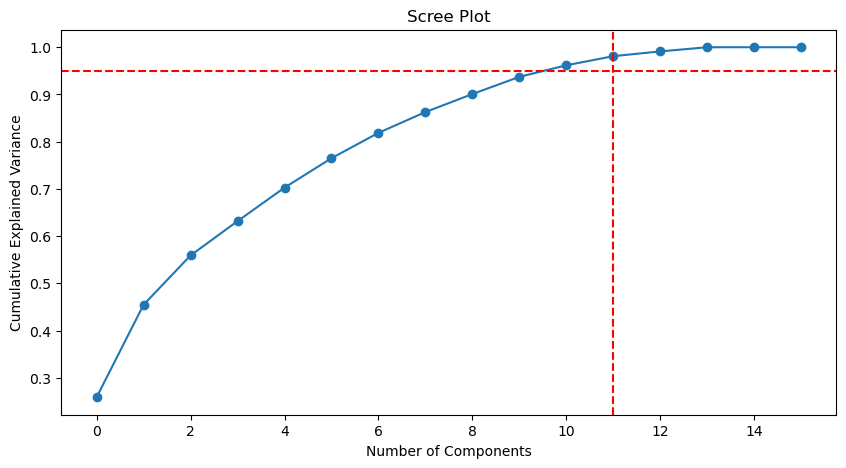

In [43]:
# Initialize PCA with no reduction to compute total variance explained
pca_full = PCA()
pca_full.fit(X.select_dtypes(include=[np.number]))

# Cumulative variance explained
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Determine the number of components to explain at least 95% of the variance
n_components_95 = (cumulative_variance < 0.95).sum() + 1

print(f"Number of components to retain 95% of the variance: {n_components_95}")

# Plotting the scree plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=n_components_95, color='r', linestyle='--')
plt.show()

# Applying PCA with the chosen number of components
pca = PCA(n_components=n_components_95)
reduced_data = pca.fit_transform(X.select_dtypes(include=[np.number]))

# Create a DataFrame for the reduced PCA data
pca_columns = ['PCA_Component_' + str(i+1) for i in range(n_components_95)]
reduced_df = pd.DataFrame(reduced_data, columns=pca_columns)

In [44]:
reduced_df.head()

,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,PCA_Component_11
0,-2.344621,2.228660,0.796298,-1.504219,-0.259579,-0.039945,0.620542,-0.493506,-0.851343,-0.042139,-0.122074
1,-2.354941,2.226579,0.791117,-1.509367,-0.260187,-0.042009,0.615118,-0.482641,-0.842409,-0.063788,-0.114447
2,-2.483197,2.200715,0.726735,-1.573336,-0.267744,-0.067651,0.547704,-0.347617,-0.731383,-0.332828,-0.019661
3,-2.483197,2.200715,0.726735,-1.573336,-0.267744,-0.067651,0.547704,-0.347617,-0.731383,-0.332828,-0.019661
4,-2.529878,2.191302,0.703302,-1.596618,-0.270495,-0.076984,0.523168,-0.298473,-0.690974,-0.430748,0.014838


In [45]:
# Essential features 'Year' and 'Area' from unmodified dataset:
essential_features = original_X[['Year', 'Area']]  # Extract from the original, unmodified dataset

# Supplementing essential features 'Year' and 'Area' alongside PCA components:
full_data_for_modeling = pd.concat([essential_features.reset_index(drop=True), reduced_df], axis=1)
print(full_data_for_modeling.columns)

Index(['Year', 'Area', 'PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3',
       'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6',
       'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9',
       'PCA_Component_10', 'PCA_Component_11'],
      dtype='object')


In [46]:
# Check if y contains more than one unique value
if y.nunique() == 1:
    print("All values in y are the same. Standardization will result in NaNs.")
else:
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Reshape y to 2D array as required by StandardScaler
    y_reshaped = y.values.reshape(-1, 1)

    # Fit and transform the data
    y_standardized = scaler.fit_transform(y_reshaped)

    # Convert back to a pandas Series
    y_standardized = pd.Series(y_standardized.flatten(), name='Total_Export_Value_Standardized')

### Split Data

Split the data into training, validation, and test sets to ensure the effectiveness of the training and validation process:

In [47]:
# Initialize the StandardScaler for the target
target_scaler = StandardScaler()

# Splitting the data into training, validation, and testing sets
x_train_reduced, x_temp_reduced, y_train_reduced, y_temp_reduced = train_test_split(
    reduced_df, 
    y, 
    test_size=0.3, 
    random_state=42
)

x_val_reduced, x_test_reduced, y_val_reduced, y_test_reduced = train_test_split(
    x_temp_reduced, 
    y_temp_reduced, 
    test_size=0.5, 
    random_state=42
)

# Convert pandas Series to NumPy array and reshape
y_train_reduced = y_train_reduced.to_numpy().reshape(-1, 1)
y_val_reduced = y_val_reduced.to_numpy().reshape(-1, 1)
y_test_reduced = y_test_reduced.to_numpy().reshape(-1, 1)

# Fit and transform the target variable for training data
y_train_scaled = target_scaler.fit_transform(y_train_reduced)

# Transform the target variable for validation and test data
y_val_scaled = target_scaler.transform(y_val_reduced)
y_test_scaled = target_scaler.transform(y_test_reduced)

# Verify shapes
print(f"x_train shape: {x_train_reduced.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"x_val shape: {x_val_reduced.shape}")
print(f"y_val shape: {y_val_scaled.shape}")
print(f"x_test shape: {x_test_reduced.shape}")
print(f"y_test shape: {y_test_scaled.shape}")

x_train shape: (266452, 11)
y_train shape: (266452, 1)
x_val shape: (57097, 11)
y_val shape: (57097, 1)
x_test shape: (57098, 11)
y_test shape: (57098, 1)


## Model Building

In [48]:
optimizer = Adam(learning_rate=0.001)

def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)), 
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        Dense(1, activation='linear')   # Output layer for regression
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Create the model
model = create_model(x_train_reduced.shape[1])

### Train Model

In [49]:
# Function to update the learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Keep the initial learning rate for the first 10 epochs
    else:
        return float(lr * tf.math.exp(-0.1).numpy())
    
    
# Set up the early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Set up the learning rate scheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Train the model with both early stopping and learning rate scheduler callbacks
history = model.fit(
    x_train_reduced, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(x_val_reduced, y_val_scaled),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.1791 - mae: 0.1423 - val_loss: 0.0321 - val_mae: 0.0650 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0463 - mae: 0.0981 - val_loss: 0.0323 - val_mae: 0.0774 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0434 - mae: 0.0974 - val_loss: 0.0293 - val_mae: 0.0748 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0418 - mae: 0.0962 - val_loss: 0.0271 - val_mae: 0.0661 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
8327


Epoch 32: LearningRateScheduler setting learning rate to 0.00011080319041546077.
Epoch 32/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0245 - mae: 0.0751 - val_loss: 0.0135 - val_mae: 0.0434 - learning_rate: 1.1080e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.00010025887707923757.
Epoch 33/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0244 - mae: 0.0754 - val_loss: 0.0129 - val_mae: 0.0402 - learning_rate: 1.0026e-04

Epoch 34: LearningRateScheduler setting learning rate to 9.071798368810334e-05.
Epoch 34/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0245 - mae: 0.0750 - val_loss: 0.0122 - val_mae: 0.0367 - learning_rate: 9.0718e-05

Epoch 35: LearningRateScheduler setting learning rate to 8.20850288890001e-05.
Epoch 35/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0242 - mae: 0.0743 - val_loss: 0.0120 - val_mae: 0.0376 - learning_rate: 8.2085e-05

Epoch 36: LearningRateScheduler setting learning rate to 7.42736034728


Epoch 63: LearningRateScheduler setting learning rate to 4.991596253129288e-06.
Epoch 63/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0232 - mae: 0.0728 - val_loss: 0.0112 - val_mae: 0.0351 - learning_rate: 4.9916e-06

Epoch 64: LearningRateScheduler setting learning rate to 4.5165830229301545e-06.
Epoch 64/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0233 - mae: 0.0729 - val_loss: 0.0113 - val_mae: 0.0354 - learning_rate: 4.5166e-06

Epoch 65: LearningRateScheduler setting learning rate to 4.086773330293263e-06.
Epoch 65/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0232 - mae: 0.0727 - val_loss: 0.0114 - val_mae: 0.0357 - learning_rate: 4.0868e-06

Epoch 66: LearningRateScheduler setting learning rate to 3.6978656424975043e-06.
Epoch 66/100
8327/8327 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0231 - mae: 0.0728 - val_loss: 0.0113 - val_mae: 0.0349 - learning_rate: 3.6979e-06
Epoch 66: early stopping
Restoring model weights from the end of the b

### Evaluate the Model and Inverse Scaling

In [50]:
# Evaluate the model
test_loss, test_mae = model.evaluate(x_test_reduced, y_test_scaled)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
y_pred_scaled = model.predict(x_test_reduced)

# Inverse transform the predictions to original scale
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)

# Compare predictions with actual values
comparison_df = pd.DataFrame({'Actual': y_test_reduced.flatten(), 'Predicted': y_pred_original.flatten()})
print(comparison_df.head())

1785/1785 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0113 - mae: 0.0345
Test Loss: 0.011285601183772087, Test MAE: 0.03443204239010811
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
        Actual    Predicted
0  10184486.00   7849718.50
1   1536844.00   2658702.75
2   6358878.17   5914624.00
3   1357368.33   1472863.75
4  24524324.85  25602662.00


### Plot Learning Curve for both training and validation loss

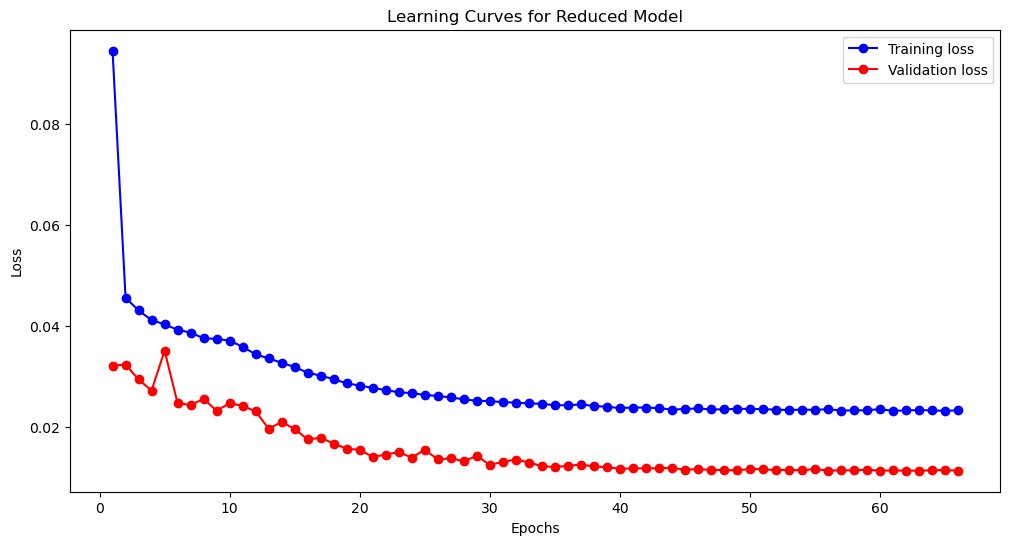

In [52]:
def plot_learning_curves(history, title='Model Learning Curves'):
    """
    This function plots the learning curves for training and validation loss from the training history.

    Args:
    history : A History object from Keras. Contains the loss values and metrics across epochs.
    title (optional): Title of the plot.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 'history_reduced' is the training history object from the reduced model
plot_learning_curves(history, "Learning Curves for Reduced Model")

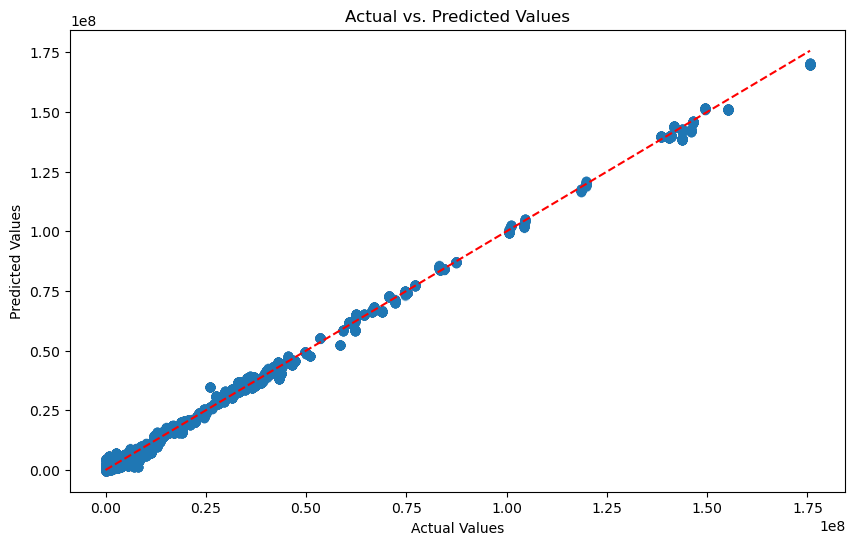

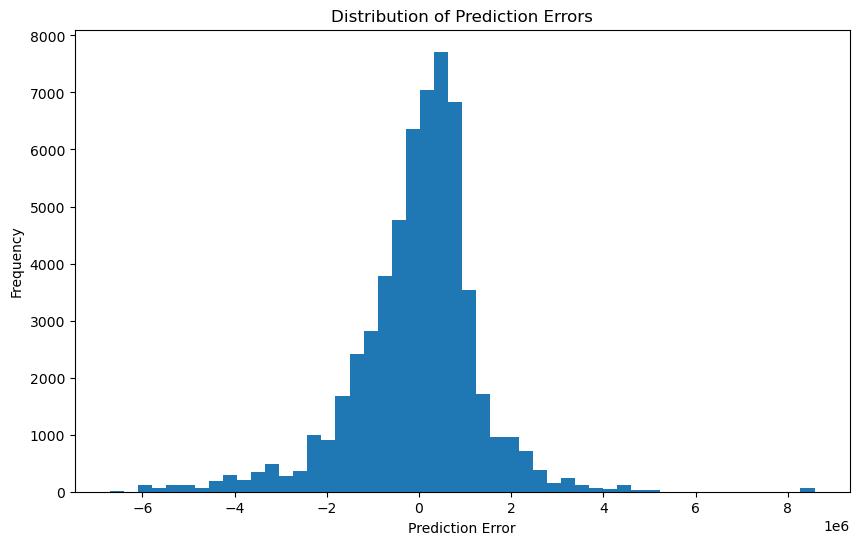

In [53]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reduced, y_pred_original, alpha=0.3)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test_reduced), max(y_test_reduced)], [min(y_test_reduced), max(y_test_reduced)], 'r--')
plt.show()

# Plotting the error distribution
errors = y_pred_original - y_test_reduced
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

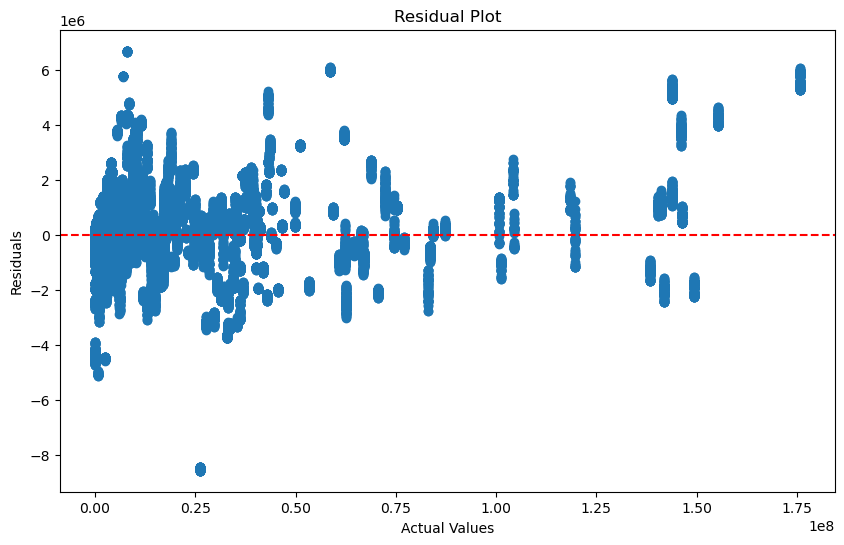

In [54]:
# Calculate residuals
residuals = y_test_reduced - y_pred_original

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reduced, residuals)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [55]:
# Predicting using the model on the test set
y_pred_scaled = model.predict(x_test_reduced)

# Inversely transforming the predictions to the original scale
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)

# Create a simple range sequence corresponding to each instance in x_test_reduced
data_instance_ids = np.arange(len(y_pred_original))

# Essential features 'Year' and 'Area' from unmodified dataset
# Split using the same indices as the test set
_, essential_features_temp, _, _ = train_test_split(
    essential_features, 
    y, 
    test_size=0.3, 
    random_state=42
)

_, essential_features_test, _, _ = train_test_split(
    essential_features_temp, 
    y_temp_reduced, 
    test_size=0.5, 
    random_state=42
)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Data_Instance_ID': data_instance_ids,
    'True_Label': y_test_reduced.flatten(),  # Flattened in case the data is 2D
    'Predicted_Label': y_pred_original.flatten()  # Flatten predictions to ensure they are 1D
})

# Set Data_Instance_ID as the index
results_df.set_index('Data_Instance_ID', inplace=True)

# Concatenate the essential features with the results DataFrame
results_df = pd.concat([essential_features_test.reset_index(drop=True), results_df], axis=1)

# Save the DataFrame to a CSV file
results_df.to_csv('model_predictions.csv')

# Print the DataFrame to verify contents
print(results_df.head())

1785/1785 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
   Year               Area   True_Label  Predicted_Label
0  2010            Ireland  10184486.00       7849718.50
1  2013            Tunisia   1536844.00       2658702.75
2  2015  Republic of Korea   6358878.17       5914624.00
3  2021             Jordan   1357368.33       1472863.75
4  2019        New Zealand  24524324.85      25602662.00
